In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

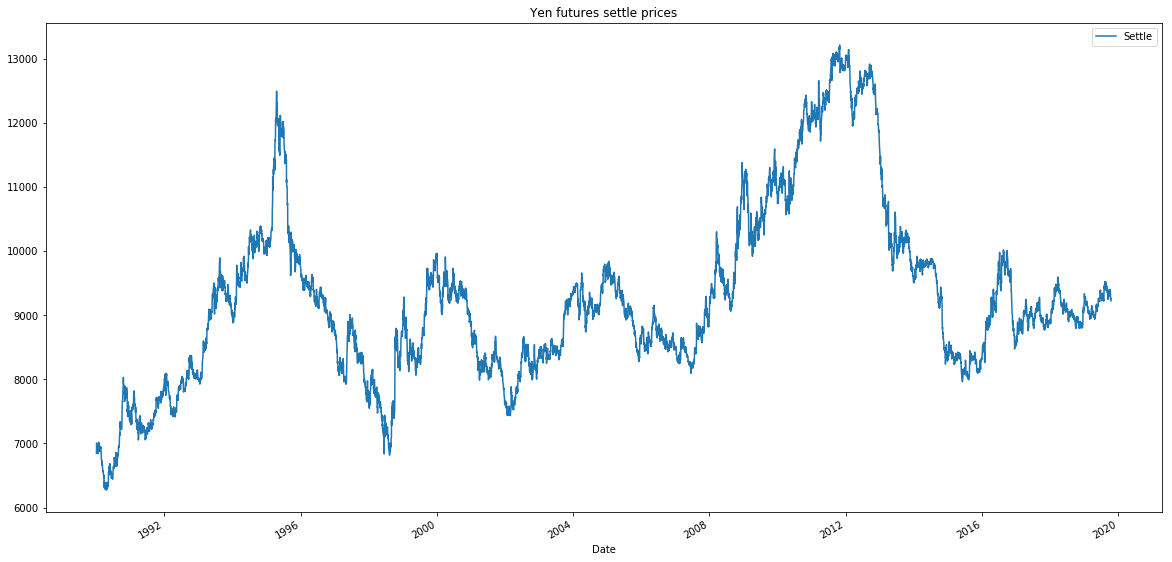

In [60]:
# Plot just the "Settle" column from the dataframe:
settle = yen_futures['Settle']
settle.plot(figsize=(20,10), title='Yen futures settle prices', legend=True)

In [1]:
The pattern in the long term of the yen settle price has big spikes of rising prices during 4 years more or less, and small spikes between these periods.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [61]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(settle)

In [63]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
df = pd.DataFrame([settle, ts_noise, ts_trend]).transpose()
df = df.rename(columns = {'Settle_cycle':'Noise', 'Settle_trend':'Trend'})
df.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


In [8]:
# Plot the Settle Price vs. the Trend for 2015 to the present

df_since_2015 = df.loc["2015-01-01":, :]
df_since_2015 = df_since_2015.drop(columns = ['Noise'])
df_since_2015

,Settle,Trend
Date,,
2015-01-02,8315.0,8394.686404
2015-01-05,8371.0,8401.395762
2015-01-06,8435.0,8408.585597
2015-01-07,8412.0,8416.089059
2015-01-08,8360.0,8423.755805
...,...,...
2019-10-09,9338.0,9313.060753
2019-10-10,9303.5,9309.368559
2019-10-11,9251.0,9305.454594


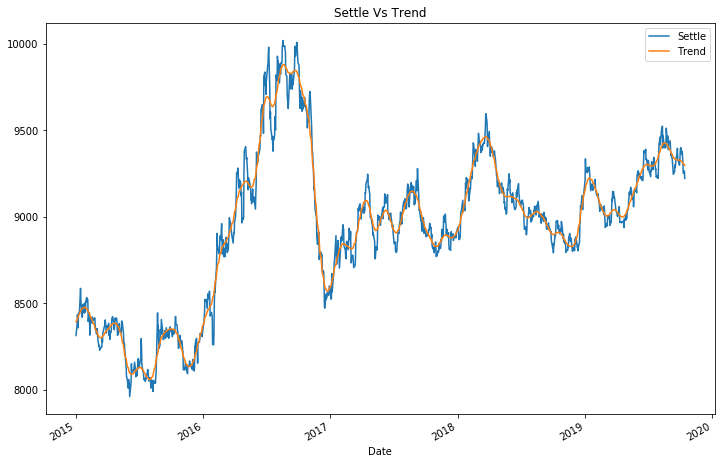

In [9]:
df_since_2015.plot(figsize = (12,8),title = "Settle Vs Trend")

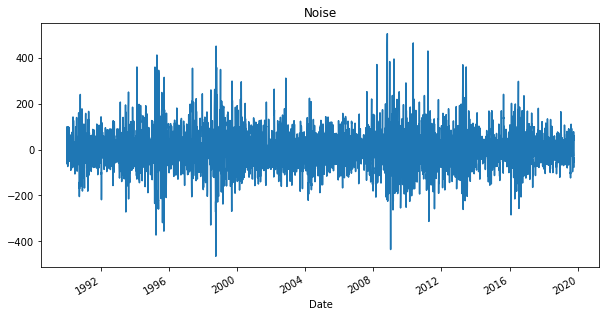

In [10]:
# Plot the Settle Noise
ts_noise.plot(figsize = (10,5),title = "Noise")

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [64]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (settle.pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

Date
2019-10-09   -0.410601
2019-10-10   -0.369458
2019-10-11   -0.564304
2019-10-14    0.151335
2019-10-15   -0.469509
Name: Settle, dtype: float64

In [16]:
import statsmodels.api as sm

In [65]:
# Estimate and ARMA model using statsmodels (use order=(2, 1))
from statsmodels.tsa.arima_model import ARMA
model = ARMA(returns.values, order=(2,1))

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [66]:
# Fit the model and assign it to a variable called results
results = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05058D+00    |proj g|=  5.17675D-04

At iterate    5    f=  1.05058D+00    |proj g|=  2.13163D-06

At iterate   10    f=  1.05058D+00    |proj g|=  6.45262D-05

At iterate   15    f=  1.05058D+00    |proj g|=  3.34555D-04

At iterate   20    f=  1.05058D+00    |proj g|=  3.06422D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     39      1     0     0   1.643D-06   1.051D+00
  F =   1.0505817371354591     

CONVERG

In [68]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 22 Feb 2022   AIC                          15798.142
Time:                        10:40:27   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.008      0.804      0.421      -0.009       0.022
ar.L1.y       -0.3064      1.277     -0.240      0.810      -2.809       2.196
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2949      1.277      0.231      0.817      -2.208       2.797
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3326           +0.0000j            3.3326            0.5000
AR.2         -157.1552           +0.0000j          157.1552            0.5000
MA.1           -3.3915           +0.0000j            3.3915            0.5000
-----------------------------------------------------------------------------
"""

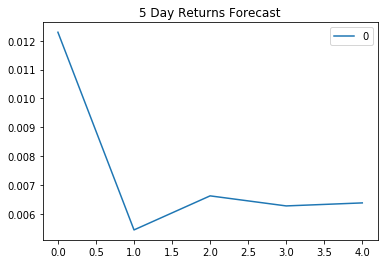

In [69]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [73]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model2 = ARIMA(df_since_2015['Settle'], order=(5, 1, 1))

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [74]:
# Fit the model
results2 = model2.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.32590D+00    |proj g|=  4.65494D-04

At iterate    5    f=  5.32575D+00    |proj g|=  2.97851D-03

At iterate   10    f=  5.32566D+00    |proj g|=  1.09868D-04

At iterate   15    f=  5.32566D+00    |proj g|=  1.68754D-06

At iterate   20    f=  5.32566D+00    |proj g|=  8.88178D-07


 This problem is unconstrained.



At iterate   25    f=  5.32566D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     44      1     0     0   1.776D-07   5.326D+00
  F =   5.3256563411176661     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [76]:
# Output model summary results:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 1205
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -6417.416
Method:                       css-mle   S.D. of innovations             49.735
Date:                Tue, 22 Feb 2022   AIC                          12850.832
Time:                        10:45:35   BIC                          12891.586
Sample:                             1   HQIC                         12866.180
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7592      1.418      0.535      0.593      -2.021       3.539
ar.L1.D.Settle    -0.7971      0.265     -3.011      0.003      -1.316      -0.278
ar.L2.D.Settle     0.0234      0.038      0.614      0.539      -0.051       0.098
ar.L3.D.Settle     0.0649      0.039      1.680      0.093      -0.011       0.141
ar.L4.D.Settle    -0.0096      0.038     -0.256      0.798      -0.083       0.064
ar.L5.D.Settle    -0.0641      0.032     -2.016      0.044      -0.126      -0.002
ma.L1.D.Settle     0.7647      0.265      2.885      0.004       0.245       1.284
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1848           -0.0000j            1.1848           -0.5000
AR.2           -1.1019           -1.3697j            1.7579           -0.3578
AR.3           -1.1019           +1.3697j            1.7579            0.3578
AR.4            1.6192           -1.2801j            2.0641           -0.1065
AR.5            1.6192           +1.2801j            2.0641            0.1065
MA.1           -1.3078           +0.0000j            1.3078            0.5000
-----------------------------------------------------------------------------
"""

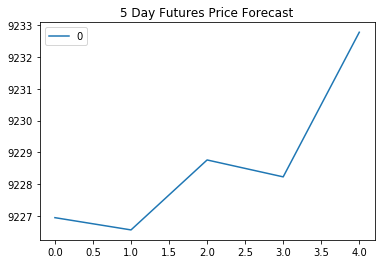

In [77]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results2.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [49]:
from arch import arch_model

In [82]:
returns = settle.pct_change() * 100
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

Date
2019-10-09   -0.410601
2019-10-10   -0.369458
2019-10-11   -0.564304
2019-10-14    0.151335
2019-10-15   -0.469509
Name: Settle, dtype: float64

In [83]:
# Estimate a GARCH model:
model3 = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

In [84]:
# Fit the model
results3 = model3.fit(disp="on")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 87406254.62884925
Iteration:      2,   Func. Count:     14,   Neg. LLF: 8220.925448485285
Iteration:      3,   Func. Count:     22,   Neg. LLF: 7487.715051647085
Iteration:      4,   Func. Count:     28,   Neg. LLF: 7505.8233985962215
Iteration:      5,   Func. Count:     34,   Neg. LLF: 7479.046068867134
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7895.737484233749
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7462.4113697930225
Iteration:      8,   Func. Count:     52,   Neg. LLF: 7462.2146776534555
Iteration:      9,   Func. Count:     57,   Neg. LLF: 7462.021535648443
Iteration:     10,   Func. Count:     62,   Neg. LLF: 7461.935930634227
Iteration:     11,   Func. Count:     67,   Neg. LLF: 7461.927898024664
Iteration:     12,   Func. Count:     72,   Neg. LLF: 7461.927643351801
Iteration:     13,   Func. Count:     77,   Neg. LLF: 7461.927640221216
Iteration:     14,   Func. Count:     82,   Neg. LLF: 4239912

In [85]:
# Summarize the model results
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Tue, Feb 22 2022   Df Residuals:                     7514
Time:                        10:50:01   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.707e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [86]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [87]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results3.forecast(start = last_day, horizon=forecast_horizon)
forecasts

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [88]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434032,7.475729,7.516851,7.55741,7.597418


In [89]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434032
h.2,7.475729
h.3,7.516851
h.4,7.557410
h.5,7.597418


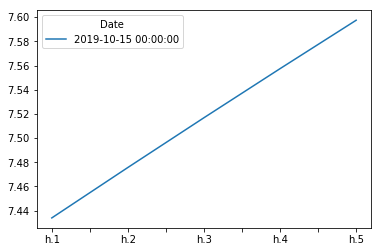

In [90]:
# Plot the final forecast
final.plot()

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

The AIC and the BIC of the ARMA and ARIMA models are high what indicates that our models have a high confidence.
The values of AIC and the BIC of the ARIMA are lower than the ARMA model, what indicates that the ARIMA model is less complex and the better to use than the ARMA model.
The P-value of both models is over 5%. That means that our data is not stationary.
The AIC and BIC of the GARCH model are high, around 14900, show us high confidence for the model. 
The p-value is low, around 0.037. It is lower than 5%, what means that the data is stationary, and is very good to predict volatility.
According to the ARIMA and GARCH models, yes I feel confident of these models for trading, and yes I would buy the yen now, but I would be a little cautios because of the expected increase of the volatility, that at the same time it means a probabitlity of higher returns.